<h1 style='color:purple' align='center'>
Data Science Regression Case Study: Predicting the Soil Moisture Content in the Soil.
</h1>


Dataset is downloaded from here: https://drive.google.com/file/d/1vzbuiyOL5ddeCSBY2ZTospiKt8qYnT1v/view

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2 style='color:blue'>1.Dataset Load: Load Soil Moisture Dataset into a Dataframe</h2>

In [2]:
df1 = pd.read_csv("soil_moisture.csv")
df1.head()

,VV,VH,smap_am,soil_moisture
0,-9.058618,-15.982408,0.284554,0.301
1,-9.511266,-18.085192,0.218601,0.172
2,-10.926619,-19.470199,0.286454,0.485
3,-8.650778,-14.840568,0.407210,0.143
4,-6.633557,-13.470629,0.420252,0.375


In [3]:
df1.shape

(30747, 4)

In [4]:
df1.columns

Index(['VV', 'VH', 'smap_am', 'soil_moisture'], dtype='object')

In [5]:
data_types = df1.dtypes
print("Data Types of Attributes\n........................")
print(data_types)

Data Types of Attributes
........................
VV               float64
VH               float64
smap_am          float64
soil_moisture    float64
dtype: object


<h2 style='color:blue'>2.Data Cleaning</h2>

<h3 style='color:blue'>2.1.Removing Duplicates - drop_duplicates()</h3>

In [6]:
# Count the number of duplicated rows
num_of_duplicates = df1.duplicated().sum()
print(f"Number of duplicated rows: {num_of_duplicates}\n")

# drop the duplicated rows from the dataframe
df1.drop_duplicates(inplace=True)
df1.reset_index(drop=True, inplace=True)
df1.head()


Number of duplicated rows: 13



,VV,VH,smap_am,soil_moisture
0,-9.058618,-15.982408,0.284554,0.301
1,-9.511266,-18.085192,0.218601,0.172
2,-10.926619,-19.470199,0.286454,0.485
3,-8.650778,-14.840568,0.407210,0.143
4,-6.633557,-13.470629,0.420252,0.375


In [7]:
# Count the number of duplicated rows after removing duplicates
num_of_duplicates = df1.duplicated().sum()
print(f"Number of duplicated rows : {num_of_duplicates}\n")

Number of duplicated rows : 0



<h3 style='color:blue'>2.2.Handling Missing Data - fillna() and dropna()</h3>

In [8]:
# Check for missing values
print("Number of missing values in each column")
print(df1.isnull().sum())

Number of missing values in each column
VV               0
VH               0
smap_am          0
soil_moisture    0
dtype: int64


<h2 style='color:blue'>3.Exploratory Data Analysis</h2>

In [9]:
print("Statistical description of numerical columns\n")
df1.describe()

Statistical description of numerical columns



,VV,VH,smap_am,soil_moisture
count,30734.000000,30734.000000,30734.000000,30734.000000
mean,-9.196386,-16.418210,0.147196,0.412658
std,2.943877,3.413933,0.121549,17.750718
min,-26.670000,-35.349515,0.000000,0.000000
25%,-10.846726,-18.015636,0.070999,0.078000
50%,-9.105106,-15.784743,0.125320,0.174000
75%,-7.631884,-14.172247,0.202307,0.279000
max,5.057968,-4.289361,0.674961,1396.570000


### VV and VH: 
#### VV (mean ≈ -9.2) being generally higher than VH (mean ≈ -16.4). They exhibit a moderate spread with standard deviations around 2.9–3.4.

### smap_am:
#### Mean = 0.147 (Range: 0.0–0.675)
#### 75% of values ≤ 0.20, suggesting right-skewed distribution.

### soil_moisture:
#### Highly skewed distribution with a mean of 0.41 but a maximum value of 1396.57, indicating strong outliers
#### The 25th, 50th, and 75th percentiles for soil_moisture are 0.078, 0.174, and 0.279, suggesting that the bulk of valid values lie below 0.3, and extreme values are likely anomalies.
#### High std for soil_moisture (17.75) confirms outlier influence.

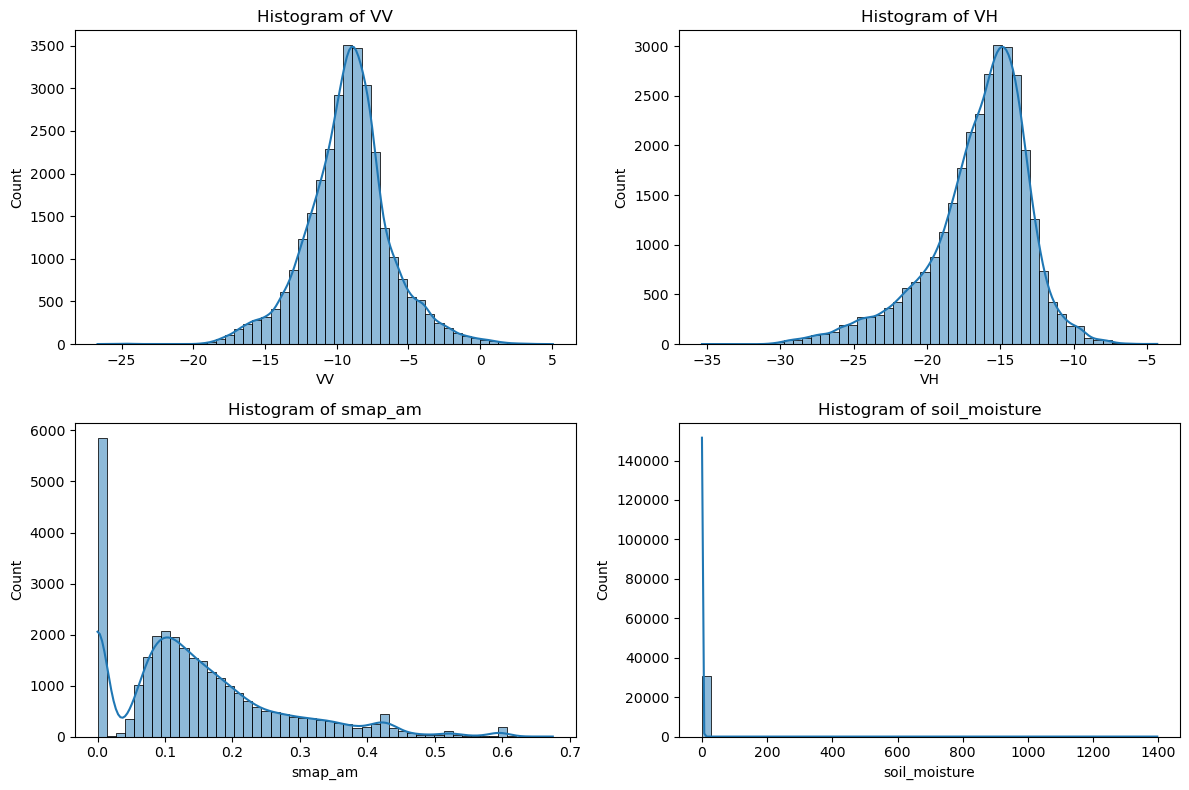

In [10]:
# for col in ['VV', 'VH', 'smap_am', 'soil_moisture']:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(df1[col], kde=True, bins=50)
#     plt.title(f'Distribution of {col}')
#     plt.show()

cols = ['VV', 'VH', 'smap_am', 'soil_moisture']

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df1[col], kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

#### VV: normally distributed VH:slightly left skewed distribution 
#### smap_am: The distribution is moderately right-skewed, indicating a concentration of low SMAP values.
#### soil_moisture: The distribution is highly right-skewed with visible extreme values (outliers). 

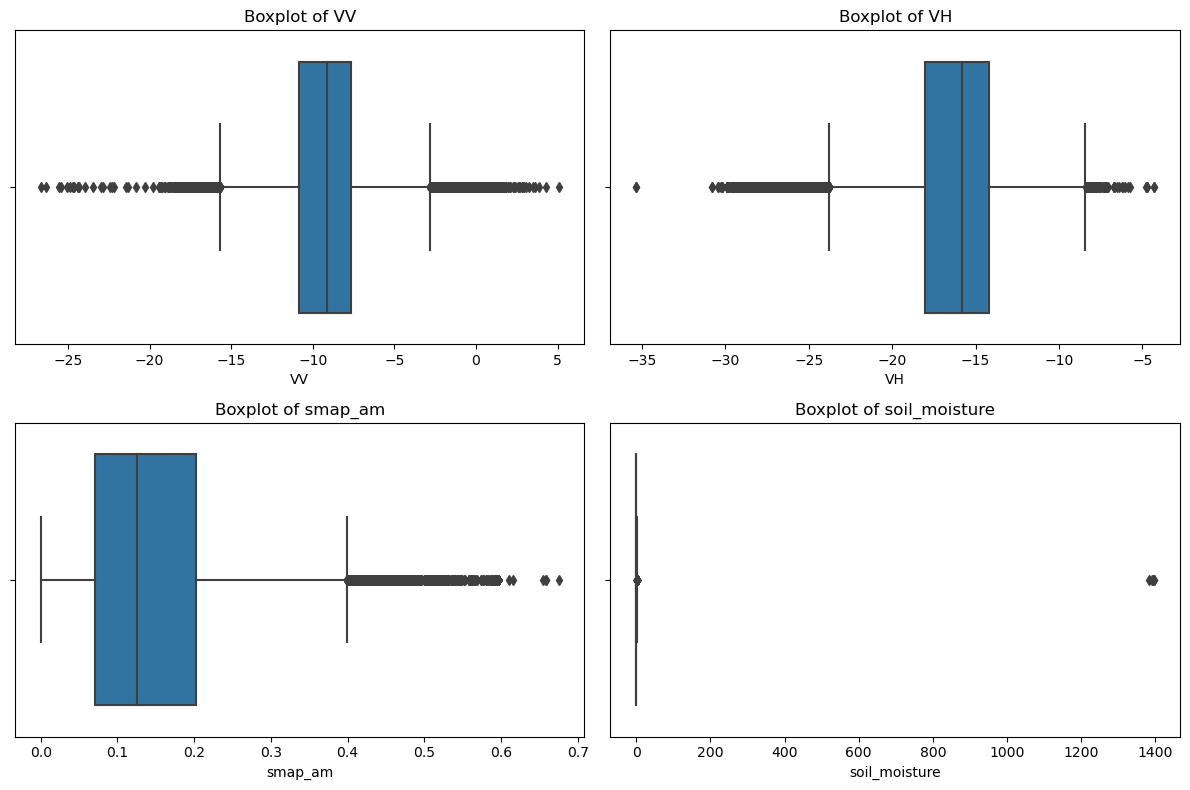

In [11]:
# for col in ['VV', 'VH', 'smap_am', 'soil_moisture']:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x=df1[col])
#     plt.title(f'Boxplot of {col}')
#     plt.show()

cols = ['VV', 'VH', 'smap_am', 'soil_moisture']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=df1[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


#### VV & VH: Both features show some mild outliers
#### smap_am: This feature has a few  moderate outliers on the higher end
#### soil_moisture: Shows significant presence of extreme outliers with values far beyond the upper whisker.

<h3 style='color:blue'>Removing Outliers - IQR</h3>

In [12]:
def count_and_remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = ((df_clean[col] < lower) | (df_clean[col] > upper)).sum()
        print(f"Number of outliers in {col}: {outliers}")
    
    # Apply filtering to remove outliers row-wise
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean

    


columns = ['VV', 'VH', 'smap_am', 'soil_moisture']
df2 = count_and_remove_outliers_iqr(df1, columns)


Number of outliers in VV: 1476
Number of outliers in VH: 1417
Number of outliers in smap_am: 1573
Number of outliers in soil_moisture: 104


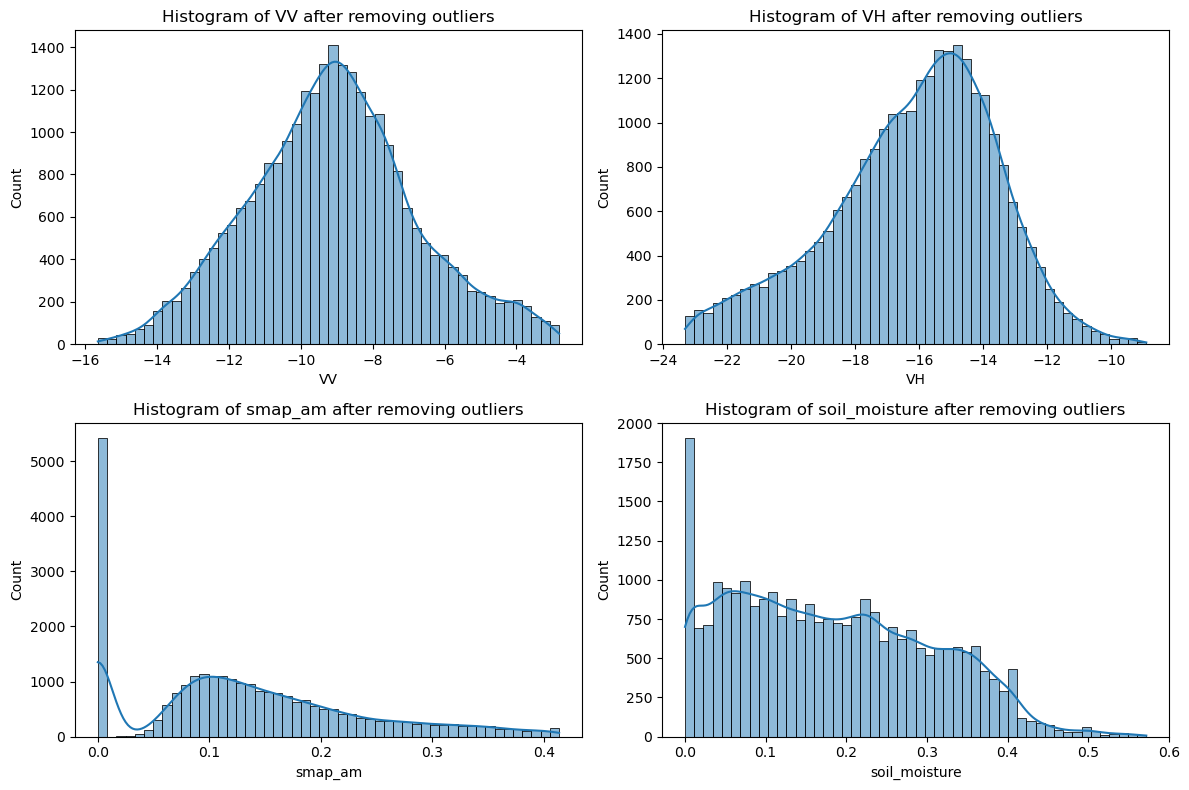

In [13]:
cols = ['VV', 'VH', 'smap_am', 'soil_moisture']

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 
# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.histplot(df2[col], kde=True, bins=50, ax=axes[i])
    axes[i].set_title(f'Histogram of {col} after removing outliers')

plt.tight_layout()
plt.show()

####  The distributions of smap_am, soil_moisture are right skewed and vv,vh has most likely normal distributions

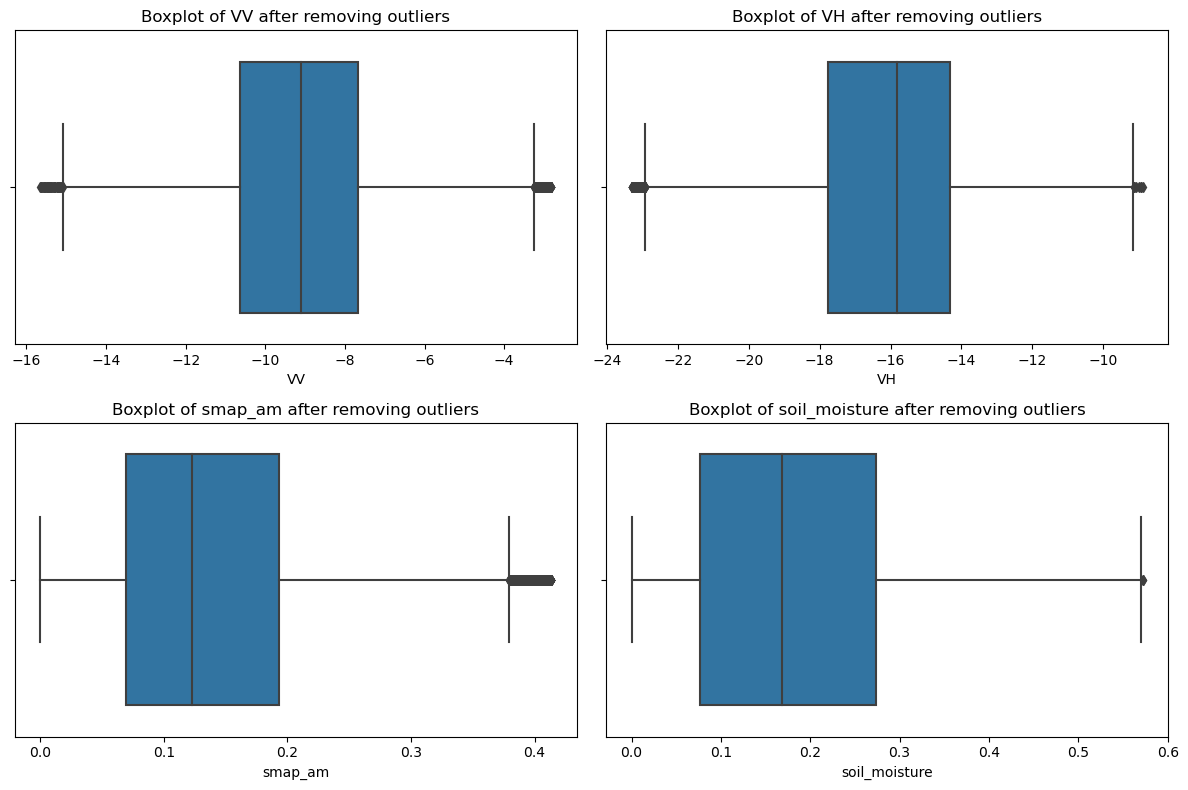

In [14]:

cols = ['VV', 'VH', 'smap_am', 'soil_moisture']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=df2[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} after removing outliers')

plt.tight_layout()
plt.show()


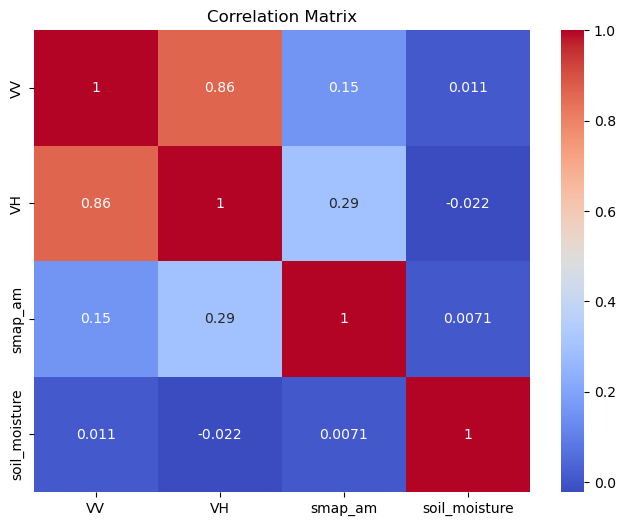

In [15]:
plt.figure(figsize=(8, 6))
sns.heatmap(df2.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

#### VV and VH are highly correlated (0.86), suggesting possible multicollinearity.
#### smap_am shows a low positive correlation with VV (0.15) and VH (0.29), indicating a weak but existent relationship.
#### soil_moisture has very weak or near-zero correlation with all input features VV( 0.011), VH(-0.022), smap_am(0.0071)
#### Note:Low correlation with soil_moisture doesn’t mean the features are useless. The relationship might be non-linear, which models like decision trees or neural networks can still learn effectively.

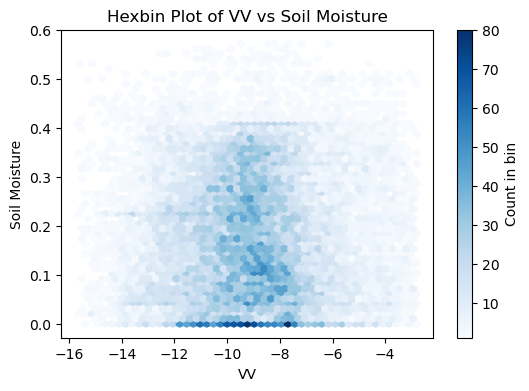

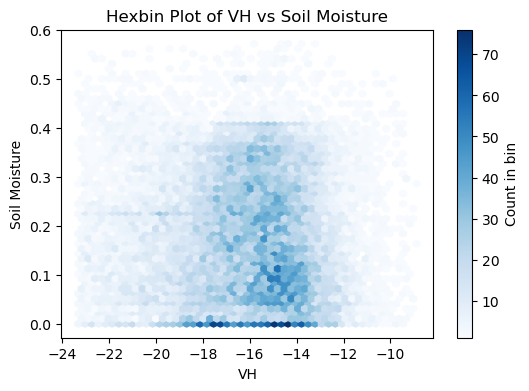

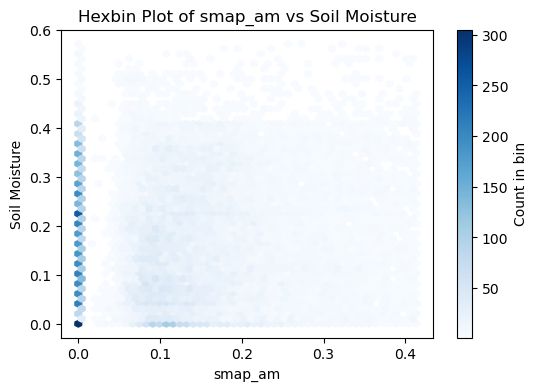

In [16]:
features = ['VV', 'VH', 'smap_am']


for feature in features:
    plt.figure(figsize=(6, 4))
    plt.hexbin(df2[feature], df2['soil_moisture'], gridsize=50, cmap='Blues', mincnt=1)
    plt.colorbar(label='Count in bin')
    plt.title(f'Hexbin Plot of {feature} vs Soil Moisture')
    plt.xlabel(feature)
    plt.ylabel('Soil Moisture')
    plt.show()


####  The data is widely scattered with no strong linear or clear non-linear patterns. The distribution of points appears random in most cases, indicating weak correlation between individual features and soil moisture values.Simple linear models may not be sufficient to capture the underlying relationships.Even non-linear models may struggle due to the lack of a strong, consistent trend in the input data.

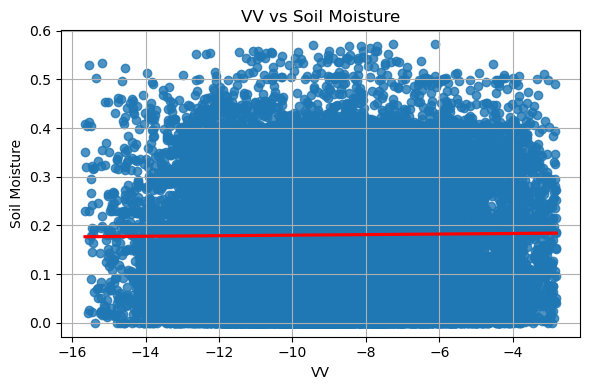

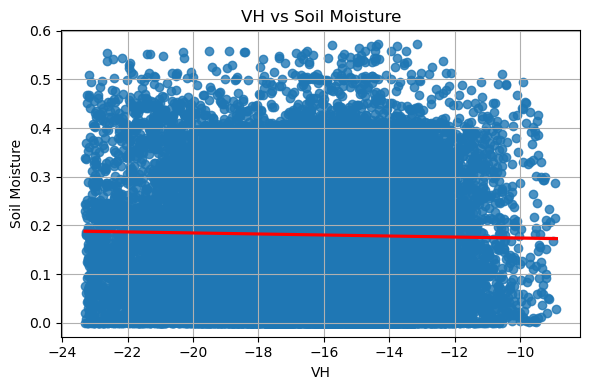

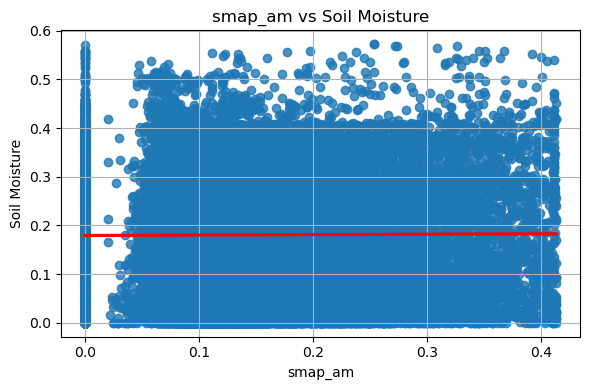

In [17]:

features_to_plot = ["VV", "VH", "smap_am"]

for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=df2[feature], y=df2["soil_moisture"], line_kws={"color": "red"})
    plt.title(f"{feature} vs Soil Moisture")
    plt.xlabel(feature)
    plt.ylabel("Soil Moisture")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### The scatter plots with linear regression lines show that the features VV, VH, and smap_am have no strong linear relationship with the target variable soil_moisture.
#### The red regression lines are nearly horizontal, indicating very low slope.
#### The data points are randomly scattered around the line with no clear trend.
#### This suggests that Simple linear models are unlikely to capture the underlying patterns.


<h2 style='color:blue'>4.Model Building</h2>

<h3 style='color:blue'>Feature Engineering</h3>

#### Initial visualizations (hexbin and regression plots) and correlation analysis showed weak and scattered relationships between raw VV, VH, smap_am and soil moisture, indicating poor linear correlation.

#### To address this, I engineered features—such as ratios, differences, vegetation indices, and interaction terms—to introduce non-linearity and enhance the model’s ability to capture complex patterns in the data.




In [18]:

# 1. Core engineered SAR features
df2["VV_VH_ratio"] = df2["VV"] / (df2["VH"] )        # Terrain-resilient ratio
df2["Delta_Index"] = df2["VV"] - df2["VH"]              # Moisture-sensitive delta
df2["RVI"] = (4 * df2["VH"]) / (df2["VV"] + df2["VH"])  # Radar Vegetation Index

# 2. Important interaction features
df2["VV_VH_interaction"] = df2["VV"] * df2["VH"]              # Nonlinear VV*VH
df2["VV_times_smap"] = df2["VV"] * df2["smap_am"]             # VV-SMAP interaction

df2.head()

,VV,VH,smap_am,soil_moisture,VV_VH_ratio,Delta_Index,RVI,VV_VH_interaction,VV_times_smap
0,-9.058618,-15.982408,0.284554,0.301,0.566787,6.923789,2.552996,144.778531,-2.577664
1,-9.511266,-18.085192,0.218601,0.172,0.525915,8.573926,2.621379,172.013072,-2.079169
2,-10.926619,-19.470199,0.286454,0.485,0.561197,8.543580,2.562136,212.743439,-3.129970
3,-8.650778,-14.840568,0.407210,0.143,0.582914,6.189790,2.526985,128.382469,-3.522682
5,-12.483400,-20.180583,0.220504,0.026,0.618585,7.697182,2.471295,251.922290,-2.752635


In [19]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


selected_features = [
    'VV', 'VH', 'smap_am',
    'VV_VH_ratio', 'Delta_Index', 'RVI',
    'VV_VH_interaction', 'VV_times_smap'
]

X = df2[selected_features]
y = df2['soil_moisture']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




 Model Evaluation
[Linear Regression] RMSE: 0.1227
[Linear Regression] R² Score: 0.0088


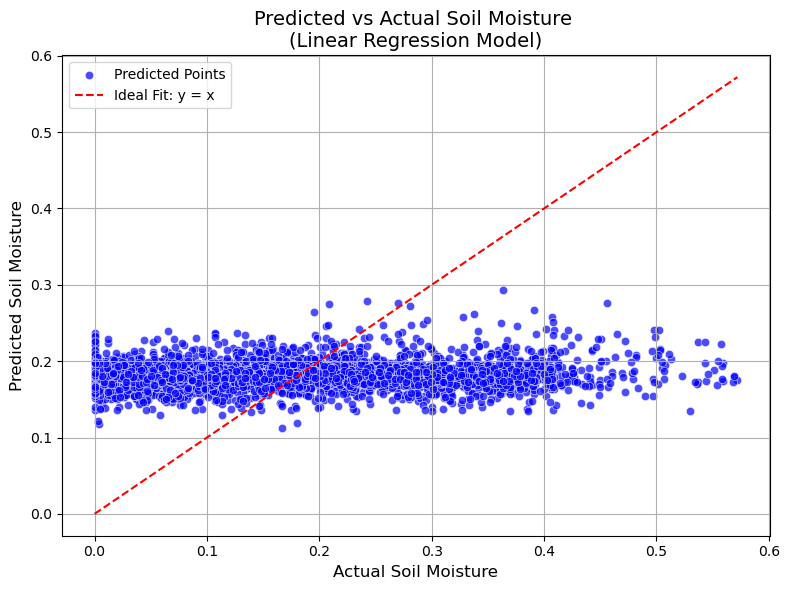

In [20]:
from sklearn.linear_model import LinearRegression

# Instantiate Linear Regression model
lr_model = LinearRegression()

# Fit the model
lr_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluating 
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\n Model Evaluation")
print(f"[Linear Regression] RMSE: {rmse_lr:.4f}")
print(f"[Linear Regression] R² Score: {r2_lr:.4f}")


plt.figure(figsize=(8, 6))

sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.7, color='blue', label='Predicted Points')

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit: y = x')

plt.xlabel('Actual Soil Moisture', fontsize=12)
plt.ylabel('Predicted Soil Moisture', fontsize=12)
plt.title('Predicted vs Actual Soil Moisture \n(Linear Regression Model)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()



 Model Evaluation
[XGBoost] RMSE: 0.1201
[XGBoost] R² Score: 0.0510


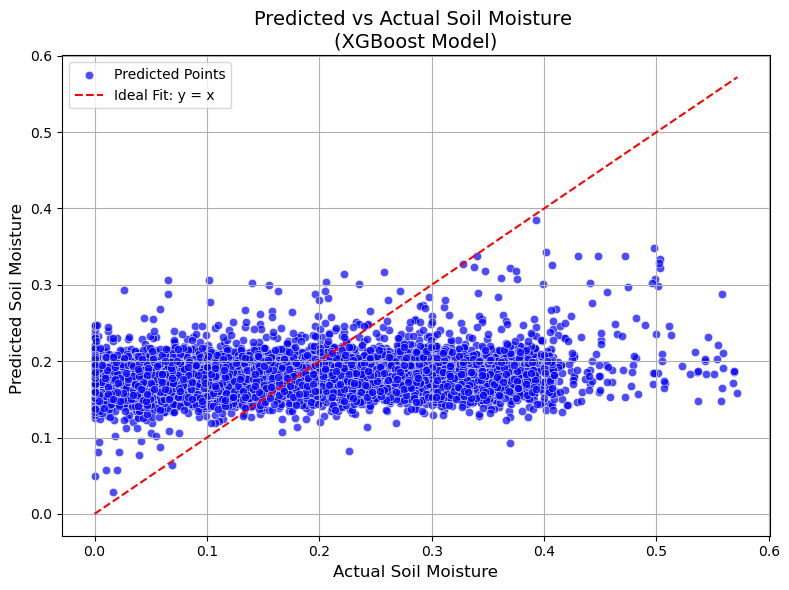

In [21]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)


xgb_model.fit(X_train_scaled, y_train)
y_pred = xgb_model.predict(X_test_scaled)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)


print("\n Model Evaluation")
print(f"[XGBoost] RMSE: {rmse_test:.4f}")
print(f"[XGBoost] R² Score: {r2_test:.4f}")


plt.figure(figsize=(8, 6))

# Scatter plot of actual vs predicted
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color='blue', label='Predicted Points')

# Diagonal line representing perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit: y = x')

plt.xlabel('Actual Soil Moisture', fontsize=12)
plt.ylabel('Predicted Soil Moisture ', fontsize=12)


plt.title('Predicted vs Actual Soil Moisture \n(XGBoost Model)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<h3 style='color:blue'>Using K Fold Cross Validation for XGBoost Model evaluation</h3>

In [22]:

from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    StandardScaler(),
    XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
)

# Define cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_rmse = np.sqrt(-cross_val_score(
    pipeline, X, y,
    scoring='neg_mean_squared_error',
    cv=kf
))

cv_r2 = cross_val_score(
    pipeline, X, y,
    scoring='r2',
    cv=kf
)

# Print results
print("Using K Fold cross-validation")
print(f"[XGBoost] RMSEs: {cv_rmse}")
print(f"[XGBoost] R² Scores: {cv_r2}")
print(f"[XGBoost] Mean RMSE: {cv_rmse.mean():.4f}")
print(f"[XGBoost] Mean R² Score: {cv_r2.mean():.4f}")

Using K Fold cross-validation
[XGBoost] RMSEs: [0.12007784 0.11925297 0.1197212  0.11843324 0.11798058]
[XGBoost] R² Scores: [0.05065814 0.05043859 0.05774584 0.06412956 0.0550598 ]
[XGBoost] Mean RMSE: 0.1191
[XGBoost] Mean R² Score: 0.0556


[Random Forest] RMSE: 0.1198
[Random Forest] R² Score: 0.0555


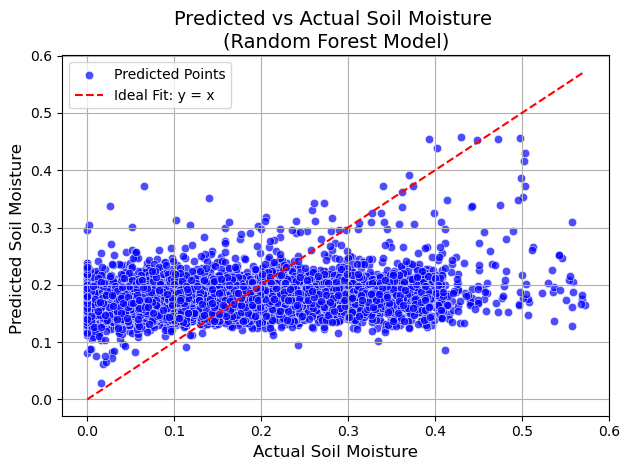

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# Train and predict
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate on test set
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"[Random Forest] RMSE: {rmse_rf:.4f}")
print(f"[Random Forest] R² Score: {r2_rf:.4f}")

# Scatter plot of actual vs predicted
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7, color='blue', label='Predicted Points')

# Diagonal line representing perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit: y = x')

plt.xlabel('Actual Soil Moisture', fontsize=12)
plt.ylabel('Predicted Soil Moisture ', fontsize=12)


plt.title('Predicted vs Actual Soil Moisture \n(Random Forest Model)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

[SVR] RMSE: 0.1201
[SVR] R² Score: 0.0508


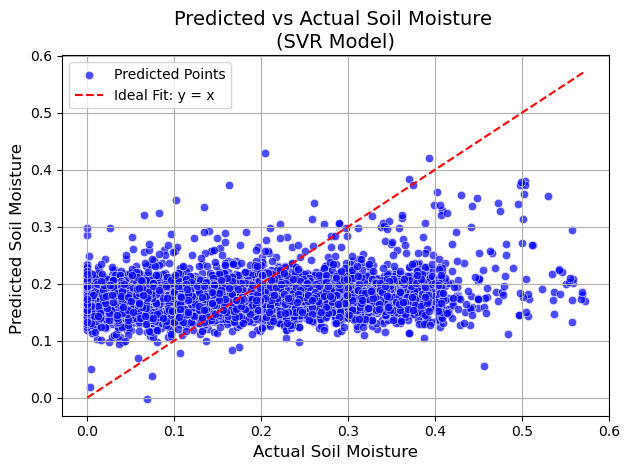

In [24]:
from sklearn.svm import SVR


svr_model = SVR(
    kernel='rbf',
    C=10,
    epsilon=0.1
)

# Train and predict
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)

# Evaluate on test set
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"[SVR] RMSE: {rmse_svr:.4f}")
print(f"[SVR] R² Score: {r2_svr:.4f}")

# Scatter plot of actual vs predicted
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7, color='blue', label='Predicted Points')

# Diagonal line representing perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit: y = x')

plt.xlabel('Actual Soil Moisture', fontsize=12)
plt.ylabel('Predicted Soil Moisture ', fontsize=12)


plt.title('Predicted vs Actual Soil Moisture \n(SVR Model)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


<h3 style='color:blue'>Grid Search CV for hyper parameter tuning for Random Forest Model</h3>

In [25]:
# from sklearn.model_selection import GridSearchCV, ShuffleSplit


# def find_best_rf_model(X, y):
#     rf = RandomForestRegressor()

#     param_grid = {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [None, 10, 20],
#         'min_samples_split': [2, 5],
#         'min_samples_leaf': [1, 2],
#         'max_features': ['sqrt', 'log2']  # 'auto' is deprecated in newer sklearn versions
#     }

#     cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

#     grid_search = GridSearchCV(
#         estimator=rf,
#         param_grid=param_grid,
#         scoring='neg_mean_squared_error',
#         cv=cv,
#         n_jobs=-1
#     )

#     grid_search.fit(X, y)

#     print("\n Best Parameters:")
#     print(grid_search.best_params_)
#     print(f"\n Best Negative MSE Score: {grid_search.best_score_:.4f}")

#     return grid_search.best_estimator_


# best_rf_model = find_best_rf_model(X, y)

# y_pred_rf_best = best_rf_model.predict(X_test)
# rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
# r2_rf = r2_score(y_test, y_pred_rf_best)

# print(f"\n [Tuned RF] RMSE: {rmse_rf:.4f}")
# print(f"\n [Tuned RF] R² Score: {r2_rf:.4f}")


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # Output layer


model.compile(optimizer='adam', loss='mse')

# Monitoring validation loss using Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history=model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


y_pred_nn = model.predict(X_test_scaled).flatten()


rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print(f"[Neural Network] RMSE: {rmse_nn:.4f}")
print(f"[Neural Network] R² Score: {r2_nn:.4f}")


Epoch 1/100


C:\Users\rajes\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


541/541 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0311 - val_loss: 0.0156
Epoch 2/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0145
Epoch 3/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0153 - val_loss: 0.0146
Epoch 4/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 5/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 6/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 7/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 8/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0148 - val_loss: 0.0145
Epoch 9/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 10/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 11/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0145 - val_loss: 0.0143
Epoch 12/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

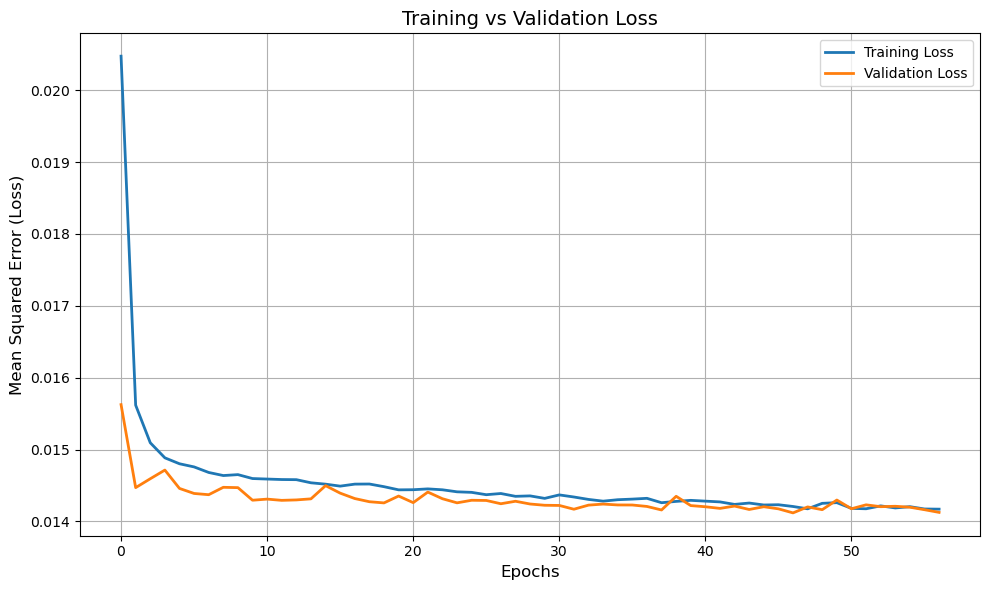

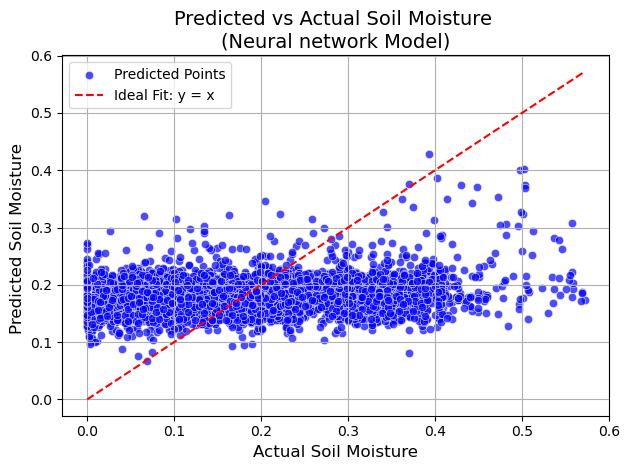

In [27]:


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (Loss)', fontsize=12)
plt.title('Training vs Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of actual vs predicted
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.7, color='blue', label='Predicted Points')

# Diagonal line representing perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit: y = x')

plt.xlabel('Actual Soil Moisture', fontsize=12)
plt.ylabel('Predicted Soil Moisture ', fontsize=12)


plt.title('Predicted vs Actual Soil Moisture \n(Neural network Model)', fontsize=14)
plt.legend(loc='upper left', fontsize=10)

# Grid and layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
